In [1]:
# load data
from google.colab import drive
drive.mount('/content/drive')

filedir = '/content/drive/MyDrive/Teaching/FWE458_Spring2024/Lec20/'
fname = filedir + "SW_with_AOD.csv"

import pandas as pd
BSRN = pd.read_csv(fname)
BSRN

Mounted at /content/drive


,SZA,AOD,COD,CLD_FRAC,UW,TO3,Pressure,BSA,WSA,SW_direct,SW_diffuse
0,24.936783,1.172892,2.440000,0.286546,2.021502,311.419861,959.085083,0.162,0.193,467.191650,300.820007
1,34.865055,1.626954,4.630000,0.468832,4.859887,308.713379,968.427551,0.155,0.169,264.900024,385.293335
2,27.330978,1.095007,2.030000,0.301414,5.278558,293.322052,988.040588,0.136,0.149,313.553314,321.538361
3,20.361732,1.126541,5.500000,0.377019,4.856422,321.498199,977.610229,0.156,0.179,143.902298,501.073639
4,13.433228,0.725452,0.736076,0.075378,0.644262,295.448975,882.321411,0.188,0.212,957.331665,79.003334
...,...,...,...,...,...,...,...,...,...,...,...
35219,37.315063,0.181112,2.360000,0.071185,2.312875,268.948242,970.049805,0.146,0.171,474.672302,207.633331
35220,64.573303,0.258045,0.392416,0.060352,0.893602,328.640442,988.746948,0.135,0.132,382.056671,74.483337
35221,61.829556,0.138252,0.233040,0.033619,2.335012,259.676788,970.049805,0.146,0.171,115.962257,281.266663
35222,67.391891,0.698632,1.368286,0.218022,0.462143,265.180176,811.828369,0.192,0.183,385.561645,50.876663


We will use decision tree regressor to build a model to predict SW radiation

In [18]:
X = BSRN[["SZA", "AOD", "COD", "CLD_FRAC", "UW", "TO3", "Pressure", "BSA", "WSA"]]
y = BSRN.SW_direct + BSRN.SW_diffuse

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn import tree

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)

treemodel = DecisionTreeRegressor(max_depth = 2)

treemodel.fit(Xtrain, ytrain)

ypred_train = treemodel.predict(Xtrain)
ypred_test = treemodel.predict(Xtest)

print(tree.export_text(treemodel))


|--- feature_0 <= 47.90
|   |--- feature_0 <= 32.56
|   |   |--- value: [851.26]
|   |--- feature_0 >  32.56
|   |   |--- value: [700.15]
|--- feature_0 >  47.90
|   |--- feature_0 <= 58.81
|   |   |--- value: [535.09]
|   |--- feature_0 >  58.81
|   |   |--- value: [360.17]



114.35997302760123


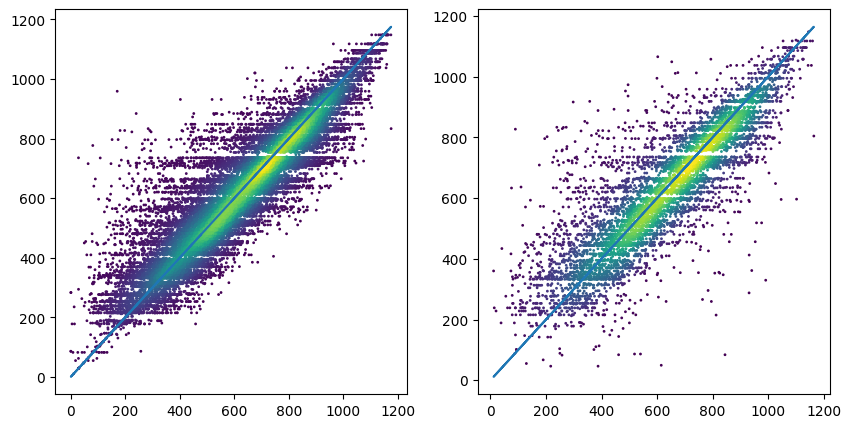

In [17]:
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import numpy as np

fig,ax = plt.subplots(1,2, figsize=[10,5])

# Calculate the point density
xy = np.vstack([ytrain,ypred_train])
z = gaussian_kde(xy)(xy)
ax[0].scatter(ytrain, ypred_train, c=z, s=1)
ax[0].plot(ytrain, ytrain, linestyle='solid')


# Calculate the point density
xy = np.vstack([ytest,ypred_test])
z = gaussian_kde(xy)(xy)
ax[1].scatter(ytest,ypred_test, c=z, s=1)
ax[1].plot(ytest, ytest, linestyle='solid')

rmse = np.sqrt(np.mean((ytest-ypred_test)**2))
print(rmse)

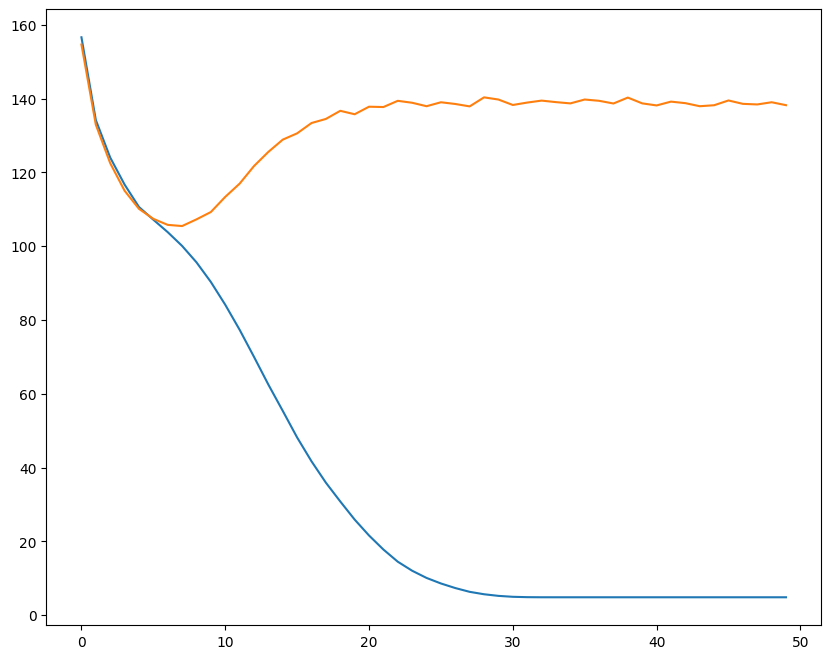

In [36]:
train_err = np.zeros(50)
test_err = np.zeros(50)

for i in range(0,50):
  treemodel = DecisionTreeRegressor(max_depth = i+1)
  treemodel.fit(Xtrain, ytrain)
  ypred_train = treemodel.predict(Xtrain)
  ypred_test = treemodel.predict(Xtest)
  train_err[i] = np.sqrt(np.mean((ytrain-ypred_train)**2))
  test_err[i] = np.sqrt(np.mean((ytest-ypred_test)**2))

fig = plt.figure(figsize=(10,8))

plt.plot(train_err)
plt.plot(test_err)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


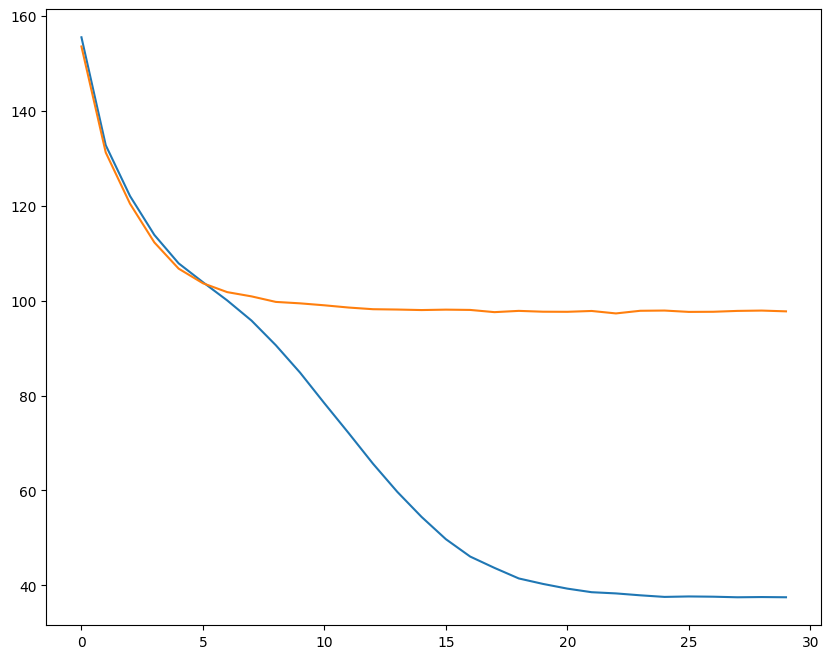

In [42]:
from sklearn.ensemble import RandomForestRegressor

train_err = np.zeros(30)
test_err = np.zeros(30)

for i in range(0,30):
  print(i)
  forest = RandomForestRegressor(100, max_depth=i+1)
  forest.fit(Xtrain, ytrain)
  ypred_train = forest.predict(Xtrain)
  ypred_test = forest.predict(Xtest)
  train_err[i] = np.sqrt(np.mean((ytrain-ypred_train)**2))
  test_err[i] = np.sqrt(np.mean((ytest-ypred_test)**2))

fig = plt.figure(figsize=(10,8))

plt.plot(train_err)
plt.plot(test_err)

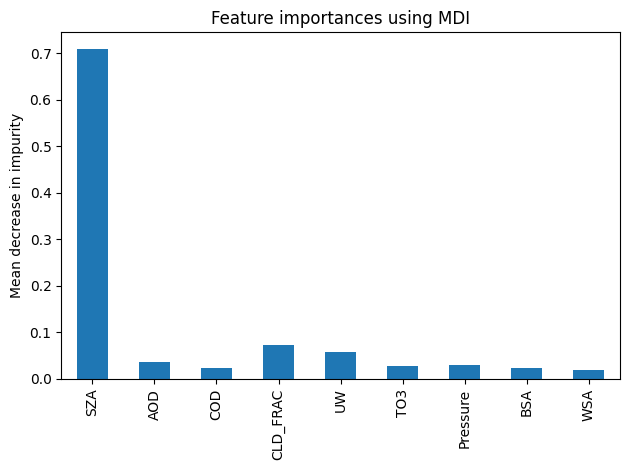

In [43]:
importances = forest.feature_importances_
importances

feature_names = ["SZA", "AOD", "COD", "CLD_FRAC", "UW", "TO3", "Pressure", "BSA", "WSA"]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()